In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload
import mio
reload(mio)
from mio import *

# Prędkości samych funkcji

In [64]:
test_sample = (np.random.random(1_000_000) - 0.5) * 5
test_sigmoid = SigmoidActivation().f
test_tanh = TanhActivation().f
test_relu = ReluActivation().f

In [65]:
%%timeit
test_sigmoid(test_sample)

12.5 ms ± 766 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
%%timeit
test_tanh(test_sample)

28 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
%%timeit
test_relu(test_sample)

5.43 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
test_dsigmoid = SigmoidActivation().df
test_dtanh = TanhActivation().df
test_drelu = ReluActivation().df

In [69]:
%%timeit
test_dsigmoid(test_sample)

15.2 ms ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%%timeit
test_dtanh(test_sample)

29.2 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
%%timeit
test_drelu(test_sample)

5.44 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


ReLU jest najszybsze, potem sigmoid, a na końcu tanh. Pochodne liczą się trochę dłużej, ale kolejność jest taka sama.

# Trochę boilerplate
Potrzebny do uruchamiania dużej ilości modeli

In [3]:
def make_regression_factory(activation):
    return NNFactory(
        BodyEndActivationStrategyFactory(activation, LinearActivation()).get(),
        LayerFactory(UniformInitializer()),
        MSELoss()
    )

def make_classification_factory(activation):
    return NNFactory(
        BodyEndActivationStrategyFactory(activation, SoftmaxActivation()).get(),
        LayerFactory(UniformInitializer()),
        CCESoftMaxLoss()
    )

nnf_reg_tanh    = make_regression_factory(TanhActivation())
nnf_reg_sigmoid = make_regression_factory(SigmoidActivation())
nnf_reg_relu    = make_regression_factory(ReluActivation())

nnf_cla_tanh    = make_classification_factory(TanhActivation())
nnf_cla_sigmoid = make_classification_factory(SigmoidActivation())
nnf_cla_relu    = make_classification_factory(ReluActivation())

In [4]:
from typing import Literal
def load_dataset(name: str, parts: Literal["training", "test", "both"], is_classification: bool):
    def load_one(path: str):
        df = pd.read_csv(path)
        x = np.array(df["x"]).reshape((df.shape[0], 1))
        y = np.array(df["y"]).reshape((df.shape[0], 1))
        if is_classification:
            c = np.array(df["c"]).reshape((df.shape[0], 1))
            return np.column_stack((x, y)), ohe(c)
        else:
            return x, y
    
    problem_kind = 'classification' if is_classification else 'regression'
    if parts != "both":
        return load_one(f"LAB1_DANE/{problem_kind}/{name}-{parts}.csv")
    else:
        return (
            load_one(f"LAB1_DANE/{problem_kind}/{name}-training.csv"),
            load_one(f"LAB1_DANE/{problem_kind}/{name}-test.csv"),
        )

In [5]:
def make_nn_and_trainer(arch, nnf: NNFactory, x, y, xt, yt, name, is_classification, interval=1000):
    nn = nnf.get(arch)
    if is_classification:
        ev = MultiClassificationEvaluator()
        tr = TimeLossTracker(interval, metric=f1_fromohe_factory(len(np.unique(rohe(y)))))
    else:
        ev = SingleRegressionEvaluator()
        tr =  TimeLossTracker(interval, metric=MSE)
    
    return Trainer(
        nn,
        x,
        y,
        x_test=xt,
        y_test=yt,
        dataset_name=name,
        evaluator=ev,
        tracker=tr
    )

# Wstępny test

In [79]:
(xmm, ymm), (xmm_test, ymm_test) = load_dataset("multimodal-large", "both", is_classification=False)
archs_reg = {"small 1-16-1": (1, 16, 1), "deep 1-16-16-16-1": (1, 16, 16, 16, 1), "wide 1-128-1": (1, 128, 1)}
nnf_reg = {"sigmoid": nnf_reg_sigmoid, "tanh":nnf_reg_tanh, "relu": nnf_reg_relu}

results = {
    arch : {
        act : (None, None) for act in nnf_reg.keys()
    } for arch in archs_reg.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_reg.items()):
    for act_name, nnf in nnf_reg.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xmm, ymm, xmm_test, ymm_test, "", False)
        nnt.momentum_method_batch(100_000)
        results[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)



Training small 1-16-1, sigmoid
MSE at 12.36s: 212.03439757186686
Training small 1-16-1, tanh
MSE at 15.39s: 1441.2705936049076
Training small 1-16-1, relu
MSE at 12.15s: 1661.3292345491927
Training deep 1-16-16-16-1, sigmoid
MSE at 25.88s: 6.6992902358914038
Training deep 1-16-16-16-1, tanh
MSE at 25.71s: 5179.2735331877545
Training deep 1-16-16-16-1, relu
MSE at 22.13s: 5177.4651048063395
Training wide 1-128-1, sigmoid
MSE at 26.07s: 5.9881506556204345
Training wide 1-128-1, tanh
MSE at 40.01s: 5.7770257087982345
Training wide 1-128-1, relu
MSE at 15.92s: 2986.6357267122835

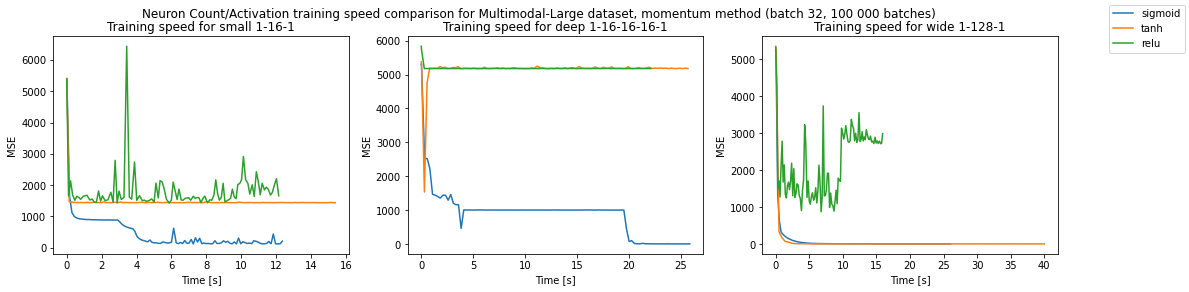

In [94]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("MSE")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Multimodal-Large dataset, momentum method (batch 32, 100 000 batches)")
plt.show()

Problemy ze stabilnością i "nasycaniem" sieci. Powtórzę eksperyment na pełnym gradiencie

In [87]:
(xmm, ymm), (xmm_test, ymm_test) = load_dataset("multimodal-large", "both", is_classification=False)
archs_reg = {"small 1-16-1": (1, 16, 1), "deep 1-16-16-16-1": (1, 16, 16, 16, 1), "wide 1-128-1": (1, 128, 1)}
nnf_reg = {"sigmoid": nnf_reg_sigmoid, "tanh":nnf_reg_tanh, "relu": nnf_reg_relu}

results2 = {
    arch : {
        act : (None, None) for act in nnf_reg.keys()
    } for arch in archs_reg.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_reg.items()):
    for act_name, nnf in nnf_reg.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xmm, ymm, xmm_test, ymm_test, "", False, interval=100)
        nnt.train_gradient(1_000)
        results2[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)



Training small 1-16-1, sigmoid
MSE at 8.73s: 3451.6590062844098
Training small 1-16-1, tanh
MSE at 14.77s: 2730.6032545008783
Training small 1-16-1, relu
MSE at 4.65s: 2587.0818302985217
Training deep 1-16-16-16-1, sigmoid
MSE at 37.32s: 2837.2370186094145
Training deep 1-16-16-16-1, tanh
MSE at 46.13s: 1412.1345826293987
Training deep 1-16-16-16-1, relu
MSE at 15.95s: 525.14266344726164
Training wide 1-128-1, sigmoid
MSE at 70.05s: 3523.6654320723032
Training wide 1-128-1, tanh
MSE at 111.14s: 2052.3970487698434
Training wide 1-128-1, relu
MSE at 34.62s: 2386.9020104136794

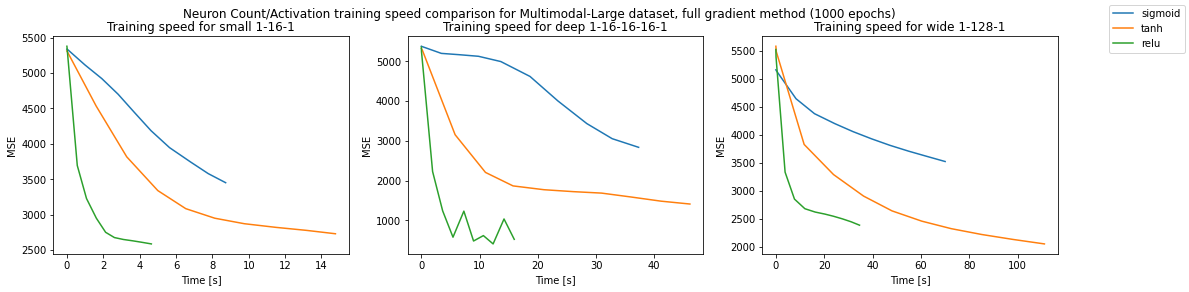

In [93]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results2.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("MSE")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Multimodal-Large dataset, full gradient method (1000 epochs)")
plt.show()

Na pełnym gradiencie relu zbiega najszybciej, ale też najmniej stabilnie i nadal MSE pozostaje duże. Co jest ciekawe, to lepsze działanie ReLU na "głębokiej" sieci, niż na "szerokiej".

# Steps large

In [98]:
(xst, yst), (xst_test, yst_test) = load_dataset("steps-large", "both", is_classification=False)
archs_reg = {"small 1-16-1": (1, 16, 1), "deep 1-16-16-16-1": (1, 16, 16, 16, 1), "wide 1-128-1": (1, 128, 1)}
nnf_reg = {"sigmoid": nnf_reg_sigmoid, "tanh":nnf_reg_tanh, "relu": nnf_reg_relu}

results3 = {
    arch : {
        act : (None, None) for act in nnf_reg.keys()
    } for arch in archs_reg.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_reg.items()):
    for act_name, nnf in nnf_reg.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xst, yst, xst_test, yst_test, "", False)
        nnt.momentum_method_batch(100_000)
        results3[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)


Training small 1-16-1, sigmoid
MSE at 13.50s: 39.409379773923026
Training small 1-16-1, tanh
MSE at 13.14s: 20.538808612670155
Training small 1-16-1, relu
MSE at 12.60s: 514.91802512083253
Training deep 1-16-16-16-1, sigmoid
MSE at 27.54s: 18.789252799255003
Training deep 1-16-16-16-1, tanh
MSE at 26.17s: 2439.0730314836784
Training deep 1-16-16-16-1, relu
MSE at 21.76s: 6833.1723674957115
Training wide 1-128-1, sigmoid
MSE at 25.90s: 36.416598978296366
Training wide 1-128-1, tanh
MSE at 40.29s: 29.971364469162847
Training wide 1-128-1, relu
MSE at 17.77s: 209.16090976581162

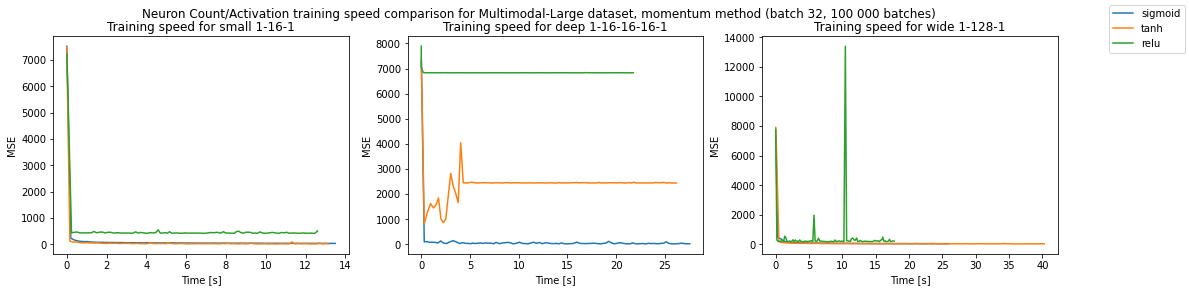

In [ ]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results3.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("MSE")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Steps-Large dataset, momentum method (batch 32, 100 000 batches)")
plt.show()

Na zbiorze steps jednocześnie są problemy ze stabilnością i minimami lokalnymi. Zdecydowanie widać to na wykresach zbieżności.

In [100]:
(xst, yst), (xst_test, yst_test) = load_dataset("steps-large", "both", is_classification=False)
archs_reg = {"small 1-16-1": (1, 16, 1), "deep 1-16-16-16-1": (1, 16, 16, 16, 1), "wide 1-128-1": (1, 128, 1)}
nnf_reg = {"sigmoid": nnf_reg_sigmoid, "tanh":nnf_reg_tanh, "relu": nnf_reg_relu}

results4 = {
    arch : {
        act : (None, None) for act in nnf_reg.keys()
    } for arch in archs_reg.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_reg.items()):
    for act_name, nnf in nnf_reg.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xst, yst, xst_test, yst_test, "", False, interval=100)
        nnt.train_gradient(1_000)
        results4[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)


Training small 1-16-1, sigmoid
MSE at 9.95s: 1064.2079510416056
Training small 1-16-1, tanh
MSE at 15.24s: 526.4028153734822
Training small 1-16-1, relu
MSE at 5.11s: 464.75185362953954
Training deep 1-16-16-16-1, sigmoid
MSE at 30.87s: 1407.7728760548732
Training deep 1-16-16-16-1, tanh
MSE at 52.16s: 205.18539717272952
Training deep 1-16-16-16-1, relu
MSE at 21.14s: 422.05451405846756
Training wide 1-128-1, sigmoid
MSE at 85.56s: 530.5258426975882
Training wide 1-128-1, tanh
MSE at 123.49s: 487.9900059426219
Training wide 1-128-1, relu
MSE at 35.96s: 434.31240709144726

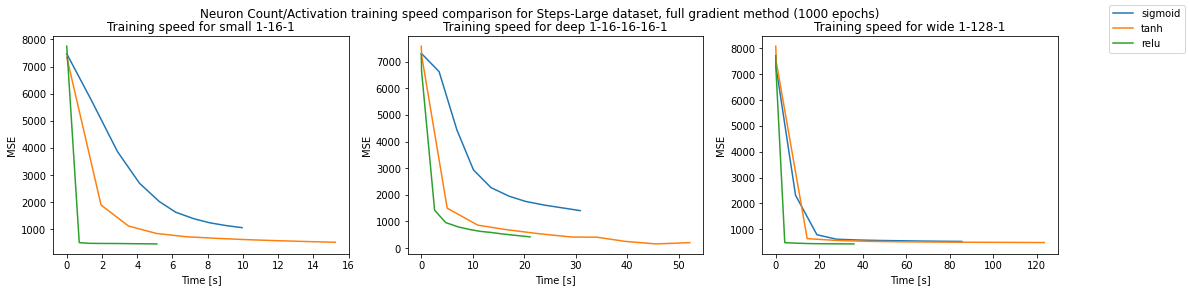

In [101]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results4.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("MSE")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Steps-Large dataset, full gradient method (1000 epochs)")
plt.show()

Steps to ten zbiór, gdzie nie działał mi pełen gradient poniżej ~400 MSE, i to chyba jest nadal prawda. Ale prędkości są podobne: ReLU najszybszy, Tanh pośrodku, Sigmoid najwolniejszy.

# Rings3

In [6]:
import warnings
warnings.filterwarnings('ignore') 
# czasami rzuca NaNami podczas liczenia F1-score

In [7]:
(xr3, yr3), (xr3_test, yr3_test) = load_dataset("rings3-regular", "both", is_classification=True)
archs_cla = {"small 2-16-3": (2, 16, 3), "deep 2-16-16-16-3": (2, 16, 16, 16, 3), "wide 2-128-3": (2, 128, 3)}
nnf_cla = {"sigmoid": nnf_cla_sigmoid, "tanh":nnf_cla_tanh, "relu": nnf_cla_relu}

results_c1 = {
    arch : {
        act : (None, None) for act in nnf_cla.keys()
    } for arch in archs_cla.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_cla.items()):
    for act_name, nnf in nnf_cla.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xr3, yr3, xr3_test, yr3_test, "", True)
        nnt.momentum_method_batch(100_000)
        results_c1[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)


Training small 2-16-3, sigmoid
f1_macro_ohe at 16.19s: 0.7875226917369279
Training small 2-16-3, tanh
f1_macro_ohe at 16.57s: 0.7283351228802523
Training small 2-16-3, relu
f1_macro_ohe at 15.03s: 0.8342500804957934
Training deep 2-16-16-16-3, sigmoid
f1_macro_ohe at 28.34s: 0.8549386854646647
Training deep 2-16-16-16-3, tanh
f1_macro_ohe at 30.49s: 0.7565994607912455
Training deep 2-16-16-16-3, relu
f1_macro_ohe at 25.26s: 0.9458910927948364
Training wide 2-128-3, sigmoid
f1_macro_ohe at 28.24s: 0.8661627852784961
Training wide 2-128-3, tanh
f1_macro_ohe at 33.43s: 0.7691820446620031
Training wide 2-128-3, relu
f1_macro_ohe at 23.58s: 0.9155895030681583

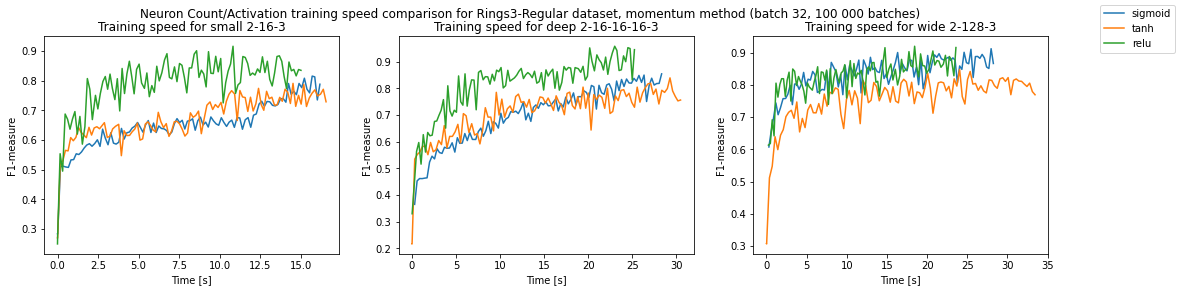

In [21]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results_c1.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("F1-measure")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Rings3-Regular dataset, momentum method (batch 32, 100 000 batches)")
plt.show()

W klasyfikacji ReLU działa najlepiej i najszybciej. Tanh i sigmoid działają podobnie.

In [9]:
(xr3, yr3), (xr3_test, yr3_test) = load_dataset("rings3-regular", "both", is_classification=True)
archs_cla = {"small 2-16-3": (2, 16, 3), "deep 2-16-16-16-3": (2, 16, 16, 16, 3), "wide 2-128-3": (2, 128, 3)}
nnf_cla = {"sigmoid": nnf_cla_sigmoid, "tanh":nnf_cla_tanh, "relu": nnf_cla_relu}

results_c2 = {
    arch : {
        act : (None, None) for act in nnf_cla.keys()
    } for arch in archs_cla.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_cla.items()):
    for act_name, nnf in nnf_cla.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xr3, yr3, xr3_test, yr3_test, "", True, interval=100)
        nnt.train_gradient(10_000)
        results_c2[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)


Training small 2-16-3, sigmoid
f1_macro_ohe at 25.34s: 0.5119878778440632
Training small 2-16-3, tanh
f1_macro_ohe at 28.67s: 0.5842053335579367
Training small 2-16-3, relu
f1_macro_ohe at 15.43s: 0.6564990262442938
Training deep 2-16-16-16-3, sigmoid
f1_macro_ohe at 76.47s: 0.41609201658010764
Training deep 2-16-16-16-3, tanh
f1_macro_ohe at 123.76s: 0.5497733823471945
Training deep 2-16-16-16-3, relu
f1_macro_ohe at 53.58s: 0.7858123245218072
Training wide 2-128-3, sigmoid
f1_macro_ohe at 191.78s: 0.6887048522404138
Training wide 2-128-3, tanh
f1_macro_ohe at 204.64s: 0.6302756051551013
Training wide 2-128-3, relu
f1_macro_ohe at 122.62s: nan 

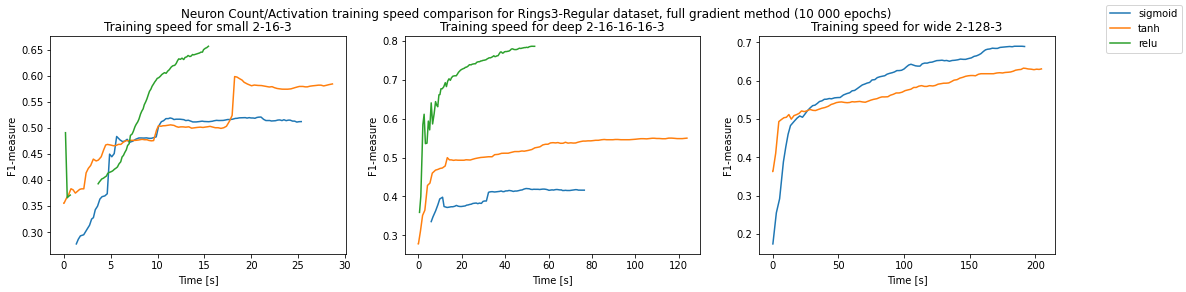

In [20]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results_c2.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("F1-measure")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Rings3-Regular dataset, full gradient method (10 000 epochs)")
plt.show()

ReLU ma problemy ze stabilnością, dla szerokiej sieci nigdy nie zbiegł do czegoś sensownego.

# Rings 5

In [13]:
(xr5, yr5), (xr5_test, yr5_test) = load_dataset("rings5-regular", "both", is_classification=True)
archs_cla = {"small 2-16-5": (2, 16, 5), "deep 2-16-16-16-5": (2, 16, 16, 16, 5), "wide 2-128-5": (2, 128, 5)}
nnf_cla = {"sigmoid": nnf_cla_sigmoid, "tanh":nnf_cla_tanh, "relu": nnf_cla_relu}

results_c3 = {
    arch : {
        act : (None, None) for act in nnf_cla.keys()
    } for arch in archs_cla.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_cla.items()):
    for act_name, nnf in nnf_cla.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xr5, yr5, xr5_test, yr5_test, "", True)
        nnt.momentum_method_batch(100_000)
        results_c3[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)


Training small 2-16-5, sigmoid
f1_macro_ohe at 17.17s: 0.8433077652657737
Training small 2-16-5, tanh
f1_macro_ohe at 16.60s: 0.6663901591369015
Training small 2-16-5, relu
f1_macro_ohe at 15.13s: 0.8001445136618763
Training deep 2-16-16-16-5, sigmoid
f1_macro_ohe at 29.64s: 0.8061996688022216
Training deep 2-16-16-16-5, tanh
f1_macro_ohe at 30.98s: 0.7418379161923198
Training deep 2-16-16-16-5, relu
f1_macro_ohe at 25.43s: 0.6564199057180488
Training wide 2-128-5, sigmoid
f1_macro_ohe at 29.08s: 0.8627113878068743
Training wide 2-128-5, tanh
f1_macro_ohe at 32.74s: 0.8264646597082571
Training wide 2-128-5, relu
f1_macro_ohe at 20.28s: nan  

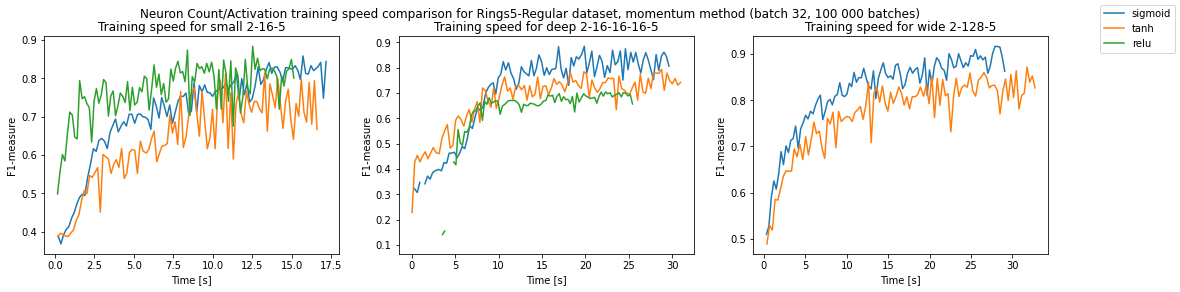

In [18]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results_c3.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("F1-measure")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Rings5-Regular dataset, momentum method (batch 32, 100 000 batches)")
plt.show()

In [14]:
(xr5, yr5), (xr5_test, yr5_test) = load_dataset("rings5-regular", "both", is_classification=True)
archs_cla = {"small 2-16-5": (2, 16, 5), "deep 2-16-16-16-5": (2, 16, 16, 16, 5), "wide 2-128-5": (2, 128, 5)}
nnf_cla = {"sigmoid": nnf_cla_sigmoid, "tanh":nnf_cla_tanh, "relu": nnf_cla_relu}

results_c4 = {
    arch : {
        act : (None, None) for act in nnf_cla.keys()
    } for arch in archs_cla.keys()
}

for idx, (arch_name, arch_spec) in enumerate(archs_cla.items()):
    for act_name, nnf in nnf_cla.items():
        print(f"\nTraining {arch_name}, {act_name}")
        nnt = make_nn_and_trainer(arch_spec, nnf, xr5, yr5, xr5_test, yr5_test, "", True, interval=100)
        nnt.train_gradient(10_000)
        results_c4[arch_name][act_name] =  (nnt.tracker.moments, nnt.tracker.records)


Training small 2-16-5, sigmoid
f1_macro_ohe at 24.85s: 0.36009050144410415
Training small 2-16-5, tanh
f1_macro_ohe at 27.28s: 0.37678866365109676
Training small 2-16-5, relu
f1_macro_ohe at 14.48s: 0.50412276097675624
Training deep 2-16-16-16-5, sigmoid
f1_macro_ohe at 75.64s: 0.31722697307400664
Training deep 2-16-16-16-5, tanh
f1_macro_ohe at 132.56s: 0.50866773920101666
Training deep 2-16-16-16-5, relu
f1_macro_ohe at 47.99s: 0.67238393881241826
Training wide 2-128-5, sigmoid
f1_macro_ohe at 171.71s: 0.48818534550304766
Training wide 2-128-5, tanh
f1_macro_ohe at 186.30s: 0.52736129101111345
Training wide 2-128-5, relu
f1_macro_ohe at 121.33s: 0.56849016017209186

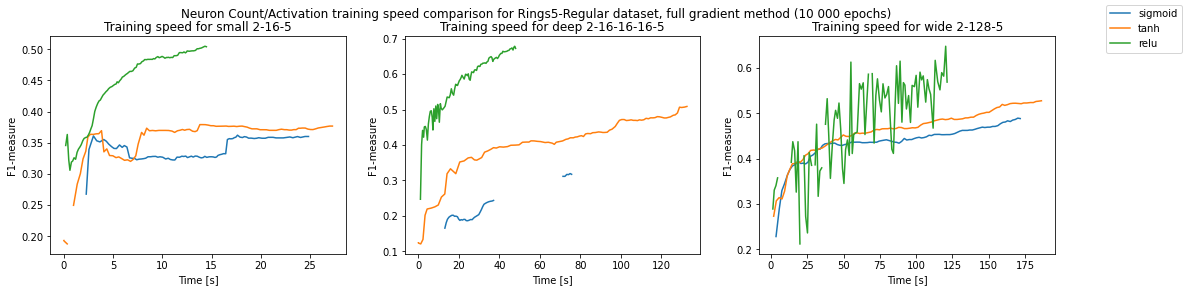

In [19]:
fig, ax = plt.subplots(1, 3)
xi, yi = fig.get_size_inches()
fig.set_size_inches(xi*3, yi)
for idx, (arch, acts) in enumerate(results_c4.items()):
    for act in acts.values():
        ax[idx].plot(act[0], act[1])
    ax[idx].set_title(f"Training speed for {arch}")
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("F1-measure")
fig.legend(["sigmoid", "tanh", "relu"])
fig.suptitle("Neuron Count/Activation training speed comparison for Rings5-Regular dataset, full gradient method (10 000 epochs)")
plt.show()

Niestety F1 często rzucał NaNami. Prawdopodobnie lepiej byłoby użyć accuracy, ale już mi się nie chce odpalać wszystkiego na nowo.
W każdym razie ReLU działa najszybciej, aczkolwiek jest najmniej stabilny.